In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=d578951ed2d4b021d2e27c020e758a9acaf8576583b7f15e966a24883c32fe69
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yunsucho","key":"fc7b4196e3f713b8895b0ed95d1bcb6b"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [02:18<00:00, 39.1MB/s]
100% 6.31G/6.31G [02:18<00:00, 48.9MB/s]


In [7]:
! unzip /content/histopathologic-cancer-detection.zip -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: datasets/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: datasets/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: datasets/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: datasets/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: datasets/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: datasets/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: datasets/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: datasets/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: datasets/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: datasets/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: datasets/train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: datasets/train/fa2ebf31ff5954570526d

In [8]:
# Libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [9]:
# Hyper parameters
num_epochs = 8
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [10]:
labels = pd.read_csv('/content/datasets/train_labels.csv')
sub = pd.read_csv('/content/datasets/sample_submission.csv')
train_path = '/content/datasets/train'
test_path = '/content/datasets/test'



In [11]:
labels.head(5)



,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [12]:
#Splitting data into train and val
train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)
len(train), len(val)

(198022, 22003)

In [13]:
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [14]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

validation_transform = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

visualization_transform = transforms.Compose([transforms.ToPILImage(),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5]
                                                                   ,std=[1.0 /0.5, 1.0 /0.5, 1.0 /0.5]
                                                                   )]) 
# Visualization_transform is for visualizaing the samples. Therefore, Un-normalized the image.



dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=train_transform)
dataset_valid = MyDataset(df_data=val, data_dir=train_path, transform=validation_transform)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)


visualization_set = MyDataset(df_data=val, data_dir=train_path, transform=visualization_transform)
visualization_loader = DataLoader(visualization_set, batch_size=32, shuffle=False, num_workers=4)

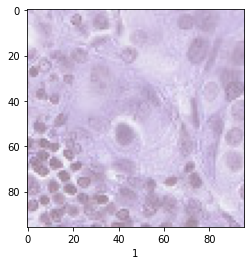

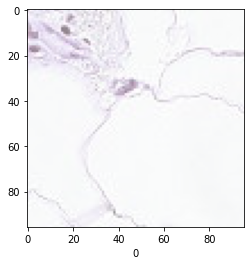

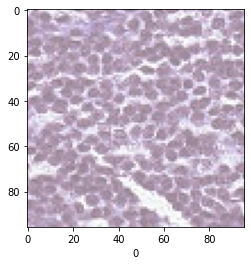

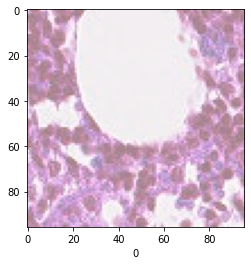

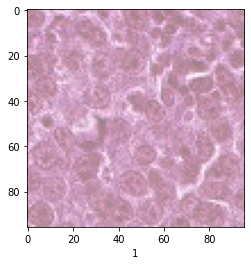

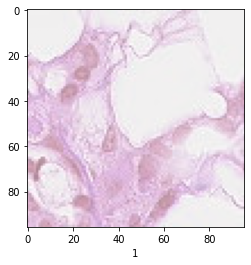

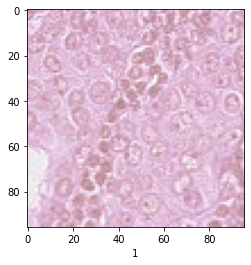

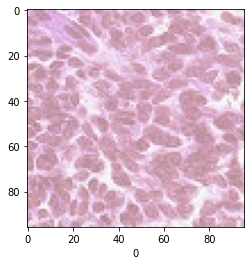

In [15]:


for ii, (inputs, labels) in enumerate(visualization_loader):
  
  for i in range(0,8):
    plt.figure()
    #plt.imshow(np.transpose(np.asarray(labels[i].squeeze()),(1,2,0)))
    plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
    plt.xlabel(labels[i].squeeze().numpy())
    #plt.imshow(inputs[i].numpy().transpose(1,2,0) )
    


  break

 

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!! Flatten the layers befor put to the fully connected layer
        x = self.fc(x)
        return x

In [17]:
model = SimpleCNN().to(device)

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [19]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
from torch.autograd import Variable

In [21]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [22]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [23]:
epoch_num = 5
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(loader_train, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(loader_valid, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 1548], [train loss 0.49720], [train acc 0.78602]
[epoch 1], [iter 200 / 1548], [train loss 0.43921], [train acc 0.81004]
[epoch 1], [iter 300 / 1548], [train loss 0.41492], [train acc 0.82167]
[epoch 1], [iter 400 / 1548], [train loss 0.40674], [train acc 0.82432]
[epoch 1], [iter 500 / 1548], [train loss 0.39876], [train acc 0.82817]
[epoch 1], [iter 600 / 1548], [train loss 0.39256], [train acc 0.83086]
[epoch 1], [iter 700 / 1548], [train loss 0.38607], [train acc 0.83412]
[epoch 1], [iter 800 / 1548], [train loss 0.37992], [train acc 0.83684]
[epoch 1], [iter 900 / 1548], [train loss 0.37477], [train acc 0.83870]
[epoch 1], [iter 1000 / 1548], [train loss 0.36730], [train acc 0.84210]
[epoch 1], [iter 1100 / 1548], [train loss 0.36318], [train acc 0.84446]
[epoch 1], [iter 1200 / 1548], [train loss 0.35810], [train acc 0.84680]
[epoch 1], [iter 1300 / 1548], [train loss 0.35283], [train acc 0.84948]
[epoch 1], [iter 1400 / 1548], [train loss 0.34719], [train 

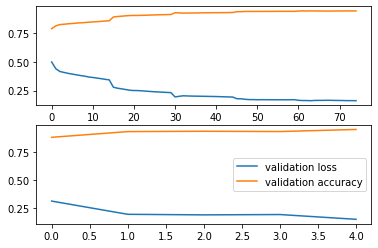

In [24]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_loss_val, label = 'validation loss')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

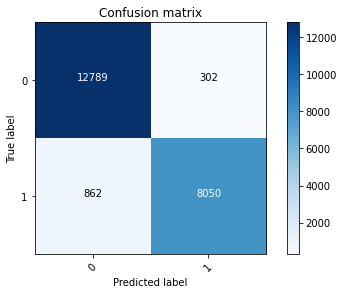

In [31]:
import itertools
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(loader_valid):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['0', '1']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [32]:
from sklearn.metrics import classification_report

In [33]:
# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     13091
           1       0.96      0.90      0.93      8912

    accuracy                           0.95     22003
   macro avg       0.95      0.94      0.94     22003
weighted avg       0.95      0.95      0.95     22003



Text(0, 0.5, 'Cancer classified incorrectly')

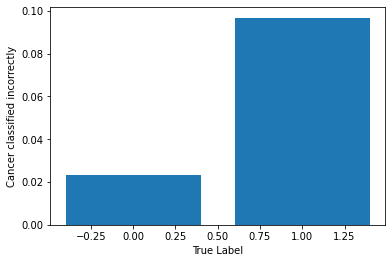

In [35]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Cancer classified incorrectly')